In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

#from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore
from mcmodels.core.voxel_model_cache import VoxelModelCache
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)


mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
#cache  = mcc
ontological_order = get_ordered_summary_structures(cache)


major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)

st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

annotation/ccf_2017


In [3]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False)
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)

512
703
1089
1097
315
313
354
698
771
803
477
549


In [4]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [5]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [6]:
#twostage_leaf_creleaf2 = Crossval()

pds = {}
for sid in major_structure_ids:
    pds[sid] = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    
#gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    print(sid)
    #print(connectivity_data.structure_datas[sid].reg_proj_norm.shape)
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    #pds = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2
    print('here')
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm[:,:], 
                                                                                       #connectivity_data.structure_datas[sid].smoothed_losses_str,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       pds[sid],                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.creleaf2_index_matrices[sid], 
                                                                                       connectivity_data.creleaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])

512
here
703
here
1089
here


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/voxel/crossvalidation.py:27: RuntimeWarning: overflow encountered in exp
  weights_i = np.exp(-dists_i * gamma)  # weights[i,:] / np.nansum(weights[i,:][otherindices])


1097
here
315
here
313
here
354
here
698
here
771
here
803
here
477
here
549
here


In [7]:

        
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)

In [8]:
from mcmodels.models.crossvalidation import Crossval

In [9]:

reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))
nw_creleaf_creleaf2 = Crossval()
nw_creleaf_creleaf2.loocvpredictions = loocvpredictions
nw_creleaf_creleaf2.losses = get_loss(reg_proj_norm, nw_creleaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
nw_creleaf_creleaf2.bestgamma  = get_best_hyperparameters(nw_creleaf_creleaf2.losses,keys)
nw_creleaf_creleaf2.meanloss = get_loss_best_hyp(nw_creleaf_creleaf2.losses, nw_creleaf_creleaf2.bestgamma)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

In [10]:
nw_creleaf_creleaf2.meanloss

array([0.04951634, 0.4966726 , 0.1013065 , 0.25932422, 0.15073582,
       0.11942033, 0.22439401, 0.07448767, 0.2385843 , 0.19429965,
       0.06370823, 0.57225383])

In [29]:
nw_creleaf_creleaf2.meanloss

array([0.04951634, 0.4966726 , 0.1013065 , 0.25932422, 0.15073582,
       0.11942033, 0.22439401, 0.07448767, 0.2385843 , 0.19429965,
       0.06370823, 0.57225383])

In [10]:
nw_creleaf_creleaf2.meanloss

array([0.04951634, 0.4966726 , 0.1013065 , 0.25932422, 0.15073582,
       0.11942033, 0.22439401, 0.07448767, 0.2385843 , 0.19429965,
       0.06370823, 0.57225383])

In [18]:
c = np.linalg.norm(connectivity_data.structure_datas[315].centroids - connectivity_data.structure_datas[315].centroids[573] , axis = 1)**2

In [12]:
wt = np.where(connectivity_data.creline[315] == 'C57BL/6J')[0]
ls = np.where(connectivity_data.leafs[315] == 721)[0]
wt_str = np.intersect1d(ls,wt)

In [13]:
wt_str = np.setdiff1d(wt_str, 573)

In [23]:
ws1 = np.exp(- (c[wt_str] - np.min(c[wt_str]))  * gammas[2])
ws1 = np.asarray(ws1, dtype = np.float32)
ws1[np.isnan(ws1)] = 0.
ws1 = ws1 / ws1.sum()
r1 = ws1  @ connectivity_data.structure_datas[315].reg_proj_norm[wt_str]
# ws2 =  np.exp(- (connectivity_data.structure_datas[315].smoothed_losses_str[573,:][indos] - 
#                  np.min(connectivity_data.structure_datas[315].smoothed_losses_str[573,:][indos]) ) * gammas[4])
# ws2 = ws2 / ws2.sum()

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


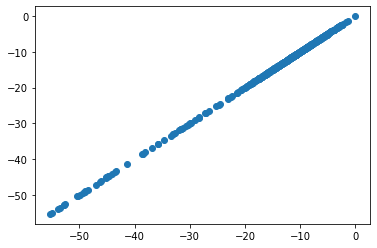

In [24]:
plt.scatter(np.log(r1), np.log(nw_creleaf_creleaf2.loocvpredictions[315][2][573]))
#nw_creleaf_creleaf2.loocvpredictions 

In [25]:
np.linalg.norm(nw_creleaf_creleaf2.loocvpredictions[315][2][573] - connectivity_data.structure_datas[315].reg_proj_norm[573])

0.34752293594594424

In [26]:
print(np.linalg.norm(r2 - connectivity_data.structure_datas[315].reg_proj_norm[573]))

NameError: name 'r2' is not defined

In [13]:
frac_learn = np.ones(12)
frac_learn[4] = .1
from mcmodels.models.expectedloss.crossvalidation import get_loss_surface_cv_spline
#sls = {}

In [14]:
#from pygam import LinearGAM,PoissonGAM, te, s, f

In [15]:





#from mcmodels.models.expectedloss.utils import get_means


In [16]:
#from mcmodels.models.expectedloss.utils import get_means


In [17]:
for m in range(12):
    #if m != 1:
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_str = get_loss_surface_cv_spline(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.leafs[sid],
                                                                                                 frac_learn[m])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/expectedloss/shapeconstrained.py:22: RuntimeWarning: invalid value encountered in true_divide
  coordinates_normed = coordinates / np.linalg.

In [22]:
from mcmodels.models.expectedloss.crossvalidation import get_embedding_cv

In [23]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    print(m)
    if m != 1:
        connectivity_data.structure_datas[sid].smoothed_losses_str = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv_str,
                                                                                  dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                                  cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_str.cre_distances_cv)

0
1
2
3
4
5
6
7
8
9
10
11


In [24]:
connectivity_data.structure_datas[703].smoothed_losses_str = connectivity_data.structure_datas[512].smoothed_losses_str

In [25]:
#try squared cre-distance

twostage_leaf_creleaf2 = Crossval()

#gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses_str,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.leaf2_index_matrices[sid], 
                                                                                       connectivity_data.leaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
            
    
    
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

twostage_leaf_creleaf2.loocvpredictions = loocvpredictions

twostage_leaf_creleaf2.losses = get_loss(reg_proj_norm, twostage_leaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
twostage_leaf_creleaf2.bestgamma  = get_best_hyperparameters(twostage_leaf_creleaf2.losses,keys)
twostage_leaf_creleaf2.meanloss = get_loss_best_hyp(twostage_leaf_creleaf2.losses, twostage_leaf_creleaf2.bestgamma)


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:30: RuntimeWarning: Mean of empty slice
  lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:77: RuntimeWarning: Mean of empty slice
  output[m] = np.nanmean(losses[sid][hyps[m], :])


In [80]:
twostage_leaf_creleaf2.meanloss #with 4 cre dist

array([0.04318187,        nan, 0.08752974, 0.23005543, 0.13814831,
       0.11903532, 0.14292968, 0.06150273, 0.23382523, 0.13422104,
       0.05455991, 0.30906268])

In [74]:
twostage_leaf_creleaf2.meanloss #with squared cre dist

array([0.05095321,        nan, 0.08714238, 0.23888684, 0.13993776,
       0.12176434, 0.14778852, 0.05988495, 0.23421037, 0.15510892,
       0.05868393, 0.29919514])

In [67]:
twostage_leaf_creleaf2.meanloss

array([0.04951634,        nan, 0.08893662, 0.2432051 , 0.14307845,
       0.12095315, 0.18268591, 0.05988432, 0.23607113, 0.18272094,
       0.05924019, 0.2979301 ])

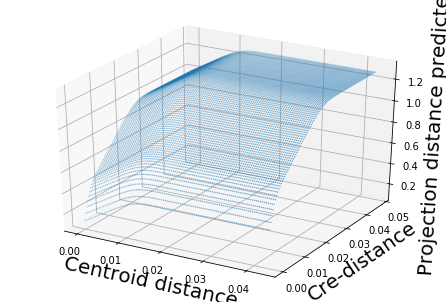

In [81]:
plot_loss_surface(connectivity_data.structure_datas[315].loss_surface_cv_str)

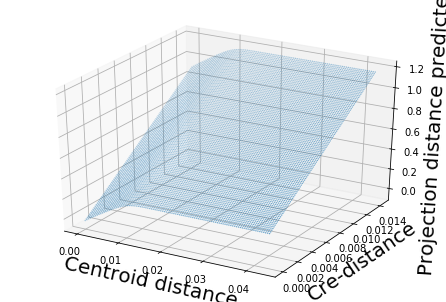

In [68]:
plot_loss_surface(connectivity_data.structure_datas[315].loss_surface_cv_str)

In [60]:
twostage_leaf_creleaf2.meanloss

array([0.07602352,        nan, 0.08683972, 0.22205456, 0.14241149,
       0.12200484, 0.22789153, 0.06054509, 0.38333502, 0.33197023,
       0.0575684 , 0.29741547])

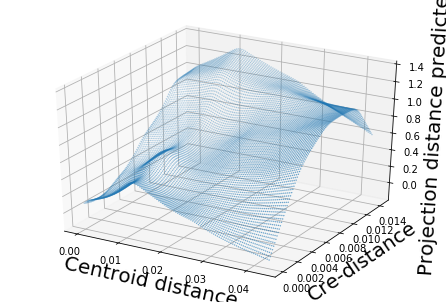

In [61]:
plot_loss_surface(connectivity_data.structure_datas[315].loss_surface_cv_str)

In [53]:
twostage_leaf_creleaf2.meanloss

array([0.07602365,        nan, 0.08893662, 0.24211676, 0.14241967,
       0.12432604, 0.22789153, 0.05990402, 0.38333502, 0.1826137 ,
       0.05890079, 0.28631609])

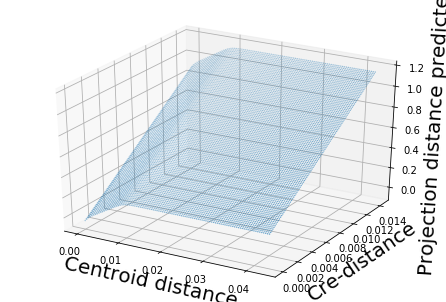

In [54]:
plot_loss_surface(connectivity_data.structure_datas[315].loss_surface_cv_str)

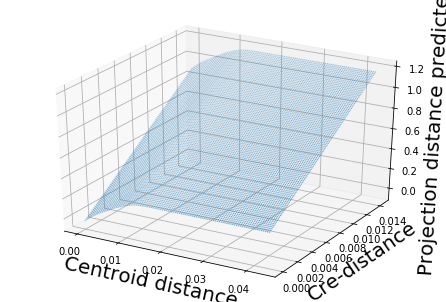

In [47]:
plot_loss_surface(connectivity_data.structure_datas[315].loss_surface_cv_str)

In [46]:
twostage_leaf_creleaf2.meanloss

array([0.04951634,        nan, 0.08893662, 0.2432051 , 0.14224639,
       0.12095315, 0.18268591, 0.05988432, 0.23607113, 0.18272094,
       0.05924019, 0.2979301 ])

In [82]:
#try to zero credist
for m in range(12):
    #if m != 1:
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv_str = get_loss_surface_cv_spline(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 np.ones(len(connectivity_data.creline[sid])),
                                                                                                 connectivity_data.leafs[sid],
                                                                                                 frac_learn[m])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/samsonkoelle/anaconda3/envs

In [85]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    print(m)
    if m != 1:
        connectivity_data.structure_datas[sid].smoothed_losses_str = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv_str,
                                                                                  dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                                  cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv_str.cre_distances_cv)

0
1
2
3
4
5
6
7
8
9
10
11


In [86]:
#try squared cre-distance

twostage_leaf_creleaf2 = Crossval()

#gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses_str,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.leaf2_index_matrices[sid], 
                                                                                       connectivity_data.leaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
            
    
    
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

twostage_leaf_creleaf2.loocvpredictions = loocvpredictions

twostage_leaf_creleaf2.losses = get_loss(reg_proj_norm, twostage_leaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
twostage_leaf_creleaf2.bestgamma  = get_best_hyperparameters(twostage_leaf_creleaf2.losses,keys)
twostage_leaf_creleaf2.meanloss = get_loss_best_hyp(twostage_leaf_creleaf2.losses, twostage_leaf_creleaf2.bestgamma)


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:157: RuntimeWarning: Mean of empty slice
  lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:425: RuntimeWarning: Mean of empty slice
  output[m] = np.nanmean(losses[sid][hyps[m], :])


In [87]:
twostage_leaf_creleaf2.meanloss

array([0.04060333,        nan, 0.11608717, 0.23316561, 0.18549859,
       0.1290228 , 0.18714683, 0.06299288, 0.26451158, 0.25808808,
       0.0804923 , 0.31071925])

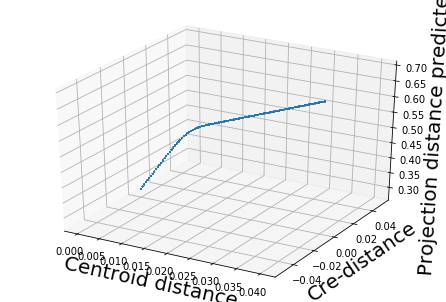

In [88]:
plot_loss_surface(connectivity_data.structure_datas[315].loss_surface_cv_str)

In [90]:
plt.scatter(connectivity_data.structure_datas[sid].smoothed_losses_str[0]

(83, 83)

In [92]:
disties = np.linalg.norm(connectivity_data.structure_datas[sid].centroids - connectivity_data.structure_datas[sid].centroids[0], axis = 1)

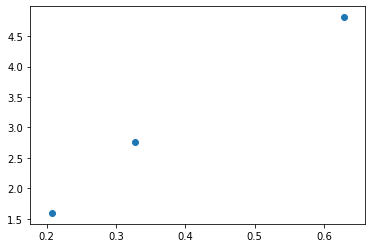

In [93]:
plt.scatter(connectivity_data.structure_datas[sid].smoothed_losses_str[0], disties)

In [94]:
#try squared cre-distance

twostage_leaf_creleaf2 = Crossval()

#gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses_str,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.creleaf2_index_matrices[sid], 
                                                                                       connectivity_data.creleaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
            
    
    
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

twostage_leaf_creleaf2.loocvpredictions = loocvpredictions

twostage_leaf_creleaf2.losses = get_loss(reg_proj_norm, twostage_leaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
twostage_leaf_creleaf2.bestgamma  = get_best_hyperparameters(twostage_leaf_creleaf2.losses,keys)
twostage_leaf_creleaf2.meanloss = get_loss_best_hyp(twostage_leaf_creleaf2.losses, twostage_leaf_creleaf2.bestgamma)


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:157: RuntimeWarning: Mean of empty slice
  lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:425: RuntimeWarning: Mean of empty slice
  output[m] = np.nanmean(losses[sid][hyps[m], :])


In [95]:
twostage_leaf_creleaf2.meanloss

array([0.04951634,        nan, 0.10075406, 0.26153446, 0.14973434,
       0.12140198, 0.22421316, 0.07496923, 0.2385843 , 0.19429311,
       0.06247885, 0.57225326])